CA3

In [ ]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import argparse
import sys
import time
from sklearn import preprocessing
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

from google.colab import drive
drive.mount("/content/gdrive")
data = pd.read_csv('/content/gdrive/My Drive/Group4_CA3_data/household_power_consumption.txt', sep=';', low_memory=False)
# print(data)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
## Preprocessing of data
# Function to load data

def get_power_data():
    """
    Read the Individual household electric power consumption dataset
    """
    
    # Assume that the dataset is located on folder "data"
    data = pd.read_csv('/content/gdrive/My Drive/Group4_CA3_data/household_power_consumption.txt', sep=';', low_memory=False)

    # Drop some non-predictive variables
    data = data.drop(columns=['Date', 'Time'], axis=1)

    #print(data.head())

    # Replace missing values
    data = data.replace('?', np.nan)

    # Drop NA
    data = data.dropna(axis=0)

    # Normalize
    standard_scaler = preprocessing.StandardScaler()
    np_scaled = standard_scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)

    # Goal variable assumed to be the first
    X = data.values[:, 1:].astype('float32')
    y = data.values[:, 0].astype('float32')

    # Create categorical y for binary classification with balanced classes
    y = np.sign(y+0.46)

    # Split train and test data here: (X_train, Y_train, X_test, Y_test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    no_class = 2                 #binary classification

    return X_train, X_test, y_train, y_test, no_class


In [ ]:
X_train, X_test, y_train, y_test, no_class = get_power_data()
print("X,y types: {} {}".format(type(X_train), type(y_train)))
print("X size {}".format(X_train.shape))
print("Y size {}".format(y_train.shape))

# Create a binary variable from one of the columns.
# You can use this OR not

idx = y_train >= 0
notidx = y_train < 0
y_train[idx] = 1
y_train[notidx] = -1

X,y types: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
X size (1536960, 6)
Y size (1536960,)


Cost function $f(w) = \frac{1}{n} \left\|w_3^T s\Big( W_2^T s (W_1^T X^T ) \Big) -y^T  \right\|_2^2 + \lambda ( \left\| W_1\right\|_2^2 + \left\| W_2\right\|_2^2 + \left\| w_3\right\|_2^2 )$  \\
Dimension setting: \\
$X: n \times d$, $\quad$ $y : n \times 1$ \\
$W_1: d \times w$ \\
$W_2: w \times w$ \\
$w_3: w \times 1$


Layer setting: \\
$l_0 =  X.T [{w\times n}]$ \\
$l_1 = s(W_1^T X)=s(l_0)  [{w\times n}]$ \\
$l_2 = s(W_2^T l_1)  [{w\times n}]$ \\
$l_3 = w_3^T l_2 [{1\times n}]$

<!-- $f(w) = \frac{1}{N} \sum_{i\in [N]} \left\| l_3 -y\right\|_2^2 + \lambda ( \left\| W_1\right\|_2^2 + \left\| W_2\right\|_2^2 + \left\| w_3\right\|_2^2 )$  \\

$y = w_3s(W_2 l_1) $  \\
$\frac{\partial y}{\partial w_2} =(w_3^T \odot s'(W_2 l_1))l_1^T$ \\

Compute gradient: \\
$ \frac{\partial f}{\partial w_3} = \frac{\partial f}{\partial l_3} \frac{\partial l_3}{\partial w_3} +2\lambda w_3=2(l_3-y) l_2^T + 2\lambda w_3 [1\times w] $ \\
<!-- $\frac{\partial f}{\partial w_2} = 2(l_3 -y)(w_3^T \odot s'(W_2 l_1))l_1^T$ \\ -->
<!-- $\frac{\partial f}{\partial w_2} = (2w_3^T(l_3-y)) \odot(s'(W_2 l_1)))  l_1^T$ \\

$ \frac{\partial f}{\partial w_1} =torch.autograd$  --> 



In [ ]:
# Sigmoid function
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

# Define weights initialization
def initialize_w(N, d):
    return 2*np.random.random((N,d)) - 1

# Fill in feed forward propagation
def feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda):
    # Fill in
    layer_0 = X.T     # d*n
    layer_1 = sigmoid(np.dot(w_1.T,layer_0)) # w*n
    layer_2 = sigmoid(np.dot(w_2.T,layer_1))    #w*n
    layer_3 = np.dot(w_3.T,layer_2)     #1*n

    return layer_0, layer_1, layer_2, layer_3
    
# Fill in backpropagation    
def back_propagation(X, y, w_1, w_2, w_3, lmbda, layer_0, layer_1, layer_2, layer_3):
    # Calculate the gradient here
    layer_3_h = layer_3 - y.reshape(1,y.shape[0])  #1*n
    # layer_2_h = np.dot(w_3, layer_3_h) * sigmoid(layer_2,True) 
    layer_2_h = np.dot(w_3, layer_3_h) * layer_2 * (1-layer_2)  #w*n
    # print(layer_2_h)
    layer_1_h = np.dot(w_2, layer_2_h) * layer_1 * (1-layer_1)  #w*n
    # layer_1_h = np.dot(w_2, layer_2_h) * sigmoid(layer_1,True) 
    # print(layer_1_h) 


    layer_3_delta = np.dot(layer_2, layer_3_h.T) # w*1
    layer_2_delta = np.dot(layer_1, layer_2_h.T) # w*w
    layer_1_delta = np.dot(layer_0, layer_1_h.T) # d*w
    return layer_1_delta, layer_2_delta, layer_3_delta

# Cost function
def cost(X, y, w_1, w_2, w_3, lmbda):
    N, d = X.shape
    a1,a2,a3,a4 = feed_forward_propagation(X,y,w_1,w_2,w_3,lmbda)
    # print(a4)
 
    # return np.linalg.norm(a4[0,:] - y.reshape(1,y.shape[0]),2) ** 2 / N  \
    #     + lmbda*(np.linalg.norm(w_1,2)+np.linalg.norm(w_2,2)+np.linalg.norm(w_3,2))
    return np.linalg.norm(a4[0,:] - y,2) ** 2 / N  

# Accuracy test function
def accuracy_func(X, y, w_1, w_2, w_3, lmbda):
    a1,a2,a3,a4 = feed_forward_propagation(X,y,w_1,w_2,w_3,lmbda)
    y_pred = a4[0,:]
    y_pred = np.sign(y_pred)
    # print(y_pred)
    # print(y)
    y_pred[y_pred == 0] = 1
    accuracy = np.mean(y_pred == y)

    return accuracy

In [ ]:
# Design algorithms

# Define GD here:
def GD(X, y, w_1,w_2,w_3, learning_rate, lmbda):
    N = X.shape[0]
    a1,a2,a3,a4 = feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda)
    layer_1_delta, layer_2_delta, layer_3_delta= back_propagation(X, y, w_1, w_2, w_3, lmbda, a1, a2, a3, a4)

    # w_3 -= learning_rate * (layer_3_delta)
    # w_2 -= learning_rate * (layer_2_delta)
    # w_1 -= learning_rate * (layer_1_delta)

    w_3 -= learning_rate * (layer_3_delta + lmbda * w_3)/N
    w_2 -= learning_rate * (layer_2_delta + lmbda * w_2)/N
    w_1 -= learning_rate * (layer_1_delta + lmbda * w_1)/N
    return w_1, w_2, w_3


# Define SGD
def SGD(X, y, w_1, w_2, w_3, learning_rate, lmbda, batch_size):
    N = X.shape[0]
    data_index = np.random.choice(N)  #Random choose the data i, using batch from [i,i+batch_size-1]
    if data_index+batch_size>N:
      a1,a2,a3,a4 = feed_forward_propagation(np.array(X[data_index:,:]), np.array(y[data_index:]),
                                           w_1, w_2, w_3, lmbda)
      layer_1_delta, layer_2_delta, layer_3_delta= back_propagation(np.array(X[data_index:]),
                            np.array(y[data_index:]), w_1, w_2, w_3, lmbda, a1, a2, a3, a4)
    else:
      a1,a2,a3,a4 = feed_forward_propagation(np.array(X[data_index:data_index+batch_size-1,:]), 
                              np.array(y[data_index:data_index+batch_size-1]),w_1, w_2, w_3, lmbda)
      layer_1_delta, layer_2_delta, layer_3_delta= back_propagation(np.array(X[data_index:data_index+batch_size-1]),
                        np.array(y[data_index:data_index+batch_size-1]), w_1, w_2, w_3, lmbda, a1, a2, a3, a4)
    
    
    
    w_3 -= learning_rate * (layer_3_delta + lmbda * w_3)/N 
    w_2 -= learning_rate * (layer_2_delta + lmbda * w_2)/N 
    w_1 -= learning_rate * (layer_1_delta + lmbda * w_1)/N

    return w_1, w_2, w_3

# Define perturbed GD here:
def PGD(X, y, w_1,w_2,w_3, learning_rate, lmbda, noise_scale):
    N = X.shape[0]
    a1,a2,a3,a4 = feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda)
    layer_1_delta, layer_2_delta, layer_3_delta= back_propagation(X, y, w_1, w_2, w_3, lmbda, a1, a2, a3, a4)
    
    w_3 -= learning_rate * (layer_3_delta + lmbda * w_3)/N + noise_scale*np.random.randn(*w_3.shape)
    w_2 -= learning_rate * (layer_2_delta + lmbda * w_2)/N + noise_scale*np.random.randn(*w_2.shape)
    w_1 -= learning_rate * (layer_1_delta + lmbda * w_1)/N + noise_scale*np.random.randn(*w_1.shape)
    return w_1, w_2, w_3


# Define SVRG here:
def SVRG(X, y, w_1, w_2, w_3, learning_rate,lmbda, T):
    N = X.shape[0]
    a1,a2,a3,a4 = feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda)
    layer_1_delta, layer_2_delta, layer_3_delta= back_propagation(X, y, w_1, w_2, w_3, lmbda, a1, a2, a3, a4)
    
    data_index = np.random.choice(N) #Randomly choose zeta_k

    c1,c2,c3,c4 = feed_forward_propagation(X[data_index:data_index+1,:],y[data_index:data_index+1],w_1,w_2,w_3,lmbda)
    grad_zeta_w_1_tilde,grad_zeta_w_2_tilde,grad_zeta_w_3_tilde = back_propagation(X[data_index:data_index+1,:],\
                                        y[data_index:data_index+1],w_1,w_2,w_3,lmbda,c1,c2,c3,c4)

    w_3_last = w_3
    w_2_last = w_2
    w_1_last = w_1
    for j in range(T):
      
      b1,b2,b3,b4 = feed_forward_propagation(X[data_index:data_index+1,:],y[data_index:data_index+1],w_1_last,w_2_last,w_3_last,lmbda)
      grad_zeta_w_1, grad_zeta_w_2, grad_zeta_w_3, = back_propagation(X[data_index:data_index+1,:],y[data_index:data_index+1],\
                                                w_1_last,w_2_last,w_3_last,lmbda,b1,b2,b3,b4)                
      
      w_3_current = w_3_last - learning_rate *(grad_zeta_w_3 -grad_zeta_w_3_tilde + layer_3_delta)/N
      w_2_current = w_2_last - learning_rate *(grad_zeta_w_2 -grad_zeta_w_2_tilde + layer_2_delta)/N
      w_1_current = w_1_last - learning_rate *(grad_zeta_w_1 -grad_zeta_w_1_tilde + layer_1_delta)/N
      
      w_3_last = w_3_current
      w_2_last = w_2_current
      w_1_last = w_1_current

    return w_1_current, w_2_current, w_3_current


# Define BCD here:
def BCD(X, y, w_1,w_2,w_3, learning_rate, lmbda):
    # Randomly choose one of w_1, w_2, w_3 to update
    N = X.shape[0]
    a1,a2,a3,a4 = feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda)
    layer_1_delta, layer_2_delta, layer_3_delta= back_propagation(X, y, w_1, w_2, w_3, lmbda, a1, a2, a3, a4)
    if np.random.choice(3)== 0:
      w_3 -= learning_rate  * (layer_3_delta + lmbda * w_3)/N
    if np.random.choice(3)== 1:
      w_2 -= learning_rate  * (layer_2_delta + lmbda * w_2)/N
    if np.random.choice(3)== 2:
      w_1 -= learning_rate  * (layer_1_delta + lmbda * w_1)/N 

    return w_1, w_2, w_3

In [ ]:
# Should be a hyperparameter that you tune, not an argument - Fill in the values
parser = argparse.ArgumentParser()
parser.add_argument('--lambda', type=float, default=1e-2, dest='lmbda') 
parser.add_argument('--w_size', type=int, default=50, dest='w_size')
parser.add_argument('--lr', type=float, default=1e-2)
parser.add_argument('--iterations', type=int, default=100)

args = parser.parse_args([])
# # Define the optimizers for the loop
# optimizers = [
#         {# Fill in the hyperparameters
#             "opt": SGD(X_train, y_train, w_1, w_2, w_3, args.lmbda, args.lr, batch_size),
#             "name": "SGD",
#             "inner": # Fill in
#         },
#         {# Fill in the hyperparameters
#             "opt": SVRG(X_train, y_train, w_1, w_2, w_3, args.lmbda, args.lr),
#             "name": "SVRG",
#             "inner": # Fill in
#         },
#         {# Fill in the hyperparameters
#             "opt": GD(X_train, y_train, w_1, w_2, w_3, learning_rate=args.lr,
#                 lmbda=args.lmbda, iterations=iterations),
#             "name": "GD",
#             "inner": # Fill in
#         },
#         {# Fill in the hyperparameters
#             "opt": PGD(
#                 X_train, y_train, w_1, w_2, w_3, learning_rate=args.lr,
#                 lmbda=args.lmbda, iterations=iterations, noise=),
#             "name": "PGD",
#             "inner": # Fill in
#         },
#         {# Fill in the hyperparameters
#             "opt": BCD(
#                 X_train, y_train, w_1, w_2, w_3, learning_rate=args.lr,
#                 lmbda=args.lmbda, iterations=iterations),
#             "name": "BCD",
#             "inner": # Fill in
#         }
#     ]

In [ ]:
# Optimization Algorithms

loss_train_GD = []

# Get iterations
iterations = args.iterations

#----------------------GD
w_1 = initialize_w(X_train.shape[1], args.w_size)
w_2 = initialize_w(args.w_size,args.w_size)
w_3 = initialize_w(args.w_size, 1)
start_GD = time.time()
for k in range(iterations):
  # print("w_3 norm:",np.linalg.norm(w_3,2))
  w_1, w_2, w_3 = GD(X_train, y_train, w_1,w_2,w_3, learning_rate=args.lr, lmbda=args.lmbda)
  loss_train_GD_temp = cost(X_train, y_train, w_1,w_2,w_3,args.lmbda)
  Acc_GD = accuracy_func(X_test, y_test, w_1, w_2, w_3, args.lmbda)
  print("GD Iteration:", k, "Loss:", loss_train_GD_temp, "Accuracy:", Acc_GD)
  loss_train_GD.append(loss_train_GD_temp)

end_GD = time.time()

GD Iteration: 0 Loss: 5.506389842499286 Accuracy: 0.49878591505309183
GD Iteration: 1 Loss: 4.044261084416999 Accuracy: 0.49878591505309183
GD Iteration: 2 Loss: 3.033574570645026 Accuracy: 0.49878591505309183
GD Iteration: 3 Loss: 2.3329081077313463 Accuracy: 0.49878591505309183
GD Iteration: 4 Loss: 1.8456987573975616 Accuracy: 0.49878591505309183
GD Iteration: 5 Loss: 1.5057197958125712 Accuracy: 0.4988932698313554
GD Iteration: 6 Loss: 1.2674175103721208 Accuracy: 0.4999082604622111
GD Iteration: 7 Loss: 1.0993996354389812 Accuracy: 0.5047392254840725
GD Iteration: 8 Loss: 0.9800080083529118 Accuracy: 0.5177701436602123
GD Iteration: 9 Loss: 0.8942898901336082 Accuracy: 0.5493988132417239
GD Iteration: 10 Loss: 0.8319177456888115 Accuracy: 0.6160290443472829
GD Iteration: 11 Loss: 0.7857568062236656 Accuracy: 0.6895768269831355
GD Iteration: 12 Loss: 0.7508771520315062 Accuracy: 0.7411246876951905
GD Iteration: 13 Loss: 0.723871755270229 Accuracy: 0.7729192692067458
GD Iteration: 1

In [ ]:
#----------------------SGD
loss_train_SGD = []
w_1 = initialize_w(X_train.shape[1], args.w_size)
w_2 = initialize_w(args.w_size,args.w_size)
w_3 = initialize_w(args.w_size, 1)
start_SGD = time.time()
for k in range(iterations):
  w_1, w_2, w_3 = SGD(X_train, y_train, w_1,w_2,w_3, 1e5* args.lr,args.lmbda, batch_size=50)
  loss_train_SGD_temp = cost(X_train, y_train, w_1,w_2,w_3,args.lmbda)
  Acc_SGD = accuracy_func(X_test, y_test, w_1, w_2, w_3, args.lmbda)
  print("SGD Iteration:", k, "Loss:", loss_train_SGD_temp, "Accuracy:", Acc_SGD)
  loss_train_SGD.append(loss_train_SGD_temp)
  
end_SGD = time.time()

SGD Iteration: 0 Loss: 1.5503018597313696 Accuracy: 0.5042414896939413
SGD Iteration: 1 Loss: 0.7841146365952302 Accuracy: 0.7304477670206121
SGD Iteration: 2 Loss: 0.5998798127973052 Accuracy: 0.7759525296689569
SGD Iteration: 3 Loss: 0.6059537149597928 Accuracy: 0.7730910368519676
SGD Iteration: 4 Loss: 0.5806136493823492 Accuracy: 0.784369144284822
SGD Iteration: 5 Loss: 0.5679434916334992 Accuracy: 0.7934982042473454
SGD Iteration: 6 Loss: 0.5596496096492858 Accuracy: 0.8013487663960025
SGD Iteration: 7 Loss: 0.5456649497400436 Accuracy: 0.806700890068707
SGD Iteration: 8 Loss: 0.5309195962254881 Accuracy: 0.8095272485946283
SGD Iteration: 9 Loss: 0.5209516843610897 Accuracy: 0.8127244690818238
SGD Iteration: 10 Loss: 0.5139562825773549 Accuracy: 0.8232335259212992
SGD Iteration: 11 Loss: 0.5030268958381108 Accuracy: 0.8215587913803872
SGD Iteration: 12 Loss: 0.5042452646077146 Accuracy: 0.832954013116802
SGD Iteration: 13 Loss: 0.4937115892365608 Accuracy: 0.8362488288569644
SGD I

In [ ]:
#----------------------PGD

loss_train_PGD = []

w_1 = initialize_w(X_train.shape[1], args.w_size)
w_2 = initialize_w(args.w_size,args.w_size)
w_3 = initialize_w(args.w_size, 1)
start_PGD = time.time()
for k in range(iterations):
  w_1, w_2, w_3 = PGD(X_train, y_train, w_1,w_2,w_3, args.lr, args.lmbda, noise_scale=1e-3)
  loss_train_PGD_temp = cost(X_train, y_train, w_1,w_2,w_3,args.lmbda)
  Acc_PGD = accuracy_func(X_test, y_test, w_1, w_2, w_3, args.lmbda)
  print("PGD Iteration:", k, "Loss:", loss_train_PGD_temp, "Accuracy:", Acc_PGD)
  loss_train_PGD.append(loss_train_PGD_temp)
  

end_PGD = time.time()

PGD Iteration: 0 Loss: 1.7084877617167036 Accuracy: 0.6369202841973767
PGD Iteration: 1 Loss: 1.519098250854942 Accuracy: 0.6466798094940662
PGD Iteration: 2 Loss: 1.4034255399316296 Accuracy: 0.6530879138038725
PGD Iteration: 3 Loss: 1.3287403643592162 Accuracy: 0.657376249219238
PGD Iteration: 4 Loss: 1.2749427952500536 Accuracy: 0.6601928482198626
PGD Iteration: 5 Loss: 1.2398845094164785 Accuracy: 0.6622052623360399
PGD Iteration: 6 Loss: 1.2091288733229557 Accuracy: 0.6649398813241724
PGD Iteration: 7 Loss: 1.1868964603850762 Accuracy: 0.6679243441599001
PGD Iteration: 8 Loss: 1.1634099773944246 Accuracy: 0.6708951436602124
PGD Iteration: 9 Loss: 1.1405173281742533 Accuracy: 0.6737702998126172
PGD Iteration: 10 Loss: 1.1175917985074961 Accuracy: 0.6777678013741412
PGD Iteration: 11 Loss: 1.0977256783561755 Accuracy: 0.6812870861961274
PGD Iteration: 12 Loss: 1.0775714229177136 Accuracy: 0.6852260306058713
PGD Iteration: 13 Loss: 1.060764404282351 Accuracy: 0.688776545908807
PGD It

In [ ]:
#----------------------SVRG
loss_train_SVRG = []

w_1 = initialize_w(X_train.shape[1], args.w_size)
w_2 = initialize_w(args.w_size,args.w_size)
w_3 = initialize_w(args.w_size, 1)
start_SVRG = time.time()
for k in range(iterations):
  w_1, w_2, w_3 = SVRG(X_train, y_train, w_1,w_2,w_3, 2*args.lr, args.lmbda, T=4)
  loss_train_SVRG_temp = cost(X_train, y_train, w_1,w_2,w_3,args.lmbda)
  Acc_SVRG = accuracy_func(X_test, y_test, w_1, w_2, w_3, args.lmbda)
  print("SVRG Iteration:", k, "Loss:", loss_train_SVRG_temp, "Accuracy:", Acc_SVRG)
  loss_train_SVRG.append(loss_train_SVRG_temp)

end_SVRG = time.time()

SVRG Iteration: 0 Loss: 1.1749826556376286 Accuracy: 0.5588304184884447
SVRG Iteration: 1 Loss: 1.031800895322712 Accuracy: 0.6152307151780138
SVRG Iteration: 2 Loss: 0.9164124536744556 Accuracy: 0.6590021861336665
SVRG Iteration: 3 Loss: 0.8229294468365357 Accuracy: 0.6946537320424735
SVRG Iteration: 4 Loss: 0.7467685523080141 Accuracy: 0.7211606027482823
SVRG Iteration: 5 Loss: 0.68440149713723 Accuracy: 0.773169113054341
SVRG Iteration: 6 Loss: 0.6330360682034251 Accuracy: 0.8030371642723297
SVRG Iteration: 7 Loss: 0.5904926336442142 Accuracy: 0.8153439256714553
SVRG Iteration: 8 Loss: 0.5550299797439764 Accuracy: 0.837806449094316
SVRG Iteration: 9 Loss: 0.5252782280898571 Accuracy: 0.8423992816989382
SVRG Iteration: 10 Loss: 0.5001368965791624 Accuracy: 0.8560801842598376
SVRG Iteration: 11 Loss: 0.4787364462185247 Accuracy: 0.8597770924422236
SVRG Iteration: 12 Loss: 0.46037548610704787 Accuracy: 0.8645982979387883
SVRG Iteration: 13 Loss: 0.44449834762931956 Accuracy: 0.86852357

In [ ]:
#----------------------BCD
loss_train_BCD = []

start_BCD = time.time()
w_1 = initialize_w(X_train.shape[1], args.w_size)
w_2 = initialize_w(args.w_size,args.w_size)
w_3 = initialize_w(args.w_size, 1)
for k in range(iterations):
  w_1, w_2, w_3 = BCD(X_train, y_train, w_1,w_2,w_3, args.lr, args.lmbda)
  loss_train_BCD_temp = cost(X_train, y_train, w_1,w_2,w_3,args.lmbda)
  Acc_BCD = accuracy_func(X_test, y_test, w_1, w_2, w_3, args.lmbda)
  print("BCD Iteration:", k, "Loss:", loss_train_BCD_temp, "Accuracy:", Acc_BCD)
  loss_train_BCD.append(loss_train_BCD_temp)

end_BCD = time.time()

BCD Iteration: 0 Loss: 5.033470400596154 Accuracy: 0.49878591505309183
BCD Iteration: 1 Loss: 5.033470400596154 Accuracy: 0.49878591505309183
BCD Iteration: 2 Loss: 5.033470400596154 Accuracy: 0.49878591505309183
BCD Iteration: 3 Loss: 3.861670745036828 Accuracy: 0.49878591505309183
BCD Iteration: 4 Loss: 3.861670745036828 Accuracy: 0.49878591505309183
BCD Iteration: 5 Loss: 3.494463441002957 Accuracy: 0.49878591505309183
BCD Iteration: 6 Loss: 2.7816198080595846 Accuracy: 0.49869417551530293
BCD Iteration: 7 Loss: 2.2778405608475327 Accuracy: 0.4970721424109931
BCD Iteration: 8 Loss: 2.2778405608475327 Accuracy: 0.4970721424109931
BCD Iteration: 9 Loss: 2.2778405608475327 Accuracy: 0.4970721424109931
BCD Iteration: 10 Loss: 1.9124346406314126 Accuracy: 0.4935957995003123
BCD Iteration: 11 Loss: 1.9039091444770866 Accuracy: 0.4936719237976265
BCD Iteration: 12 Loss: 1.644220801542246 Accuracy: 0.49017410993129296
BCD Iteration: 13 Loss: 1.644220801542246 Accuracy: 0.49017410993129296
B

Accuracy:  GD 0.8935099156777014 SGD 0.9042941911305434 PGD 0.8865220955652717 SVRG 0.9340119456589632 BGD 0.908069175515303
Training time:  GD: 1190 SGD 537 PGD 1316 SVRG 1222 BGD 1224


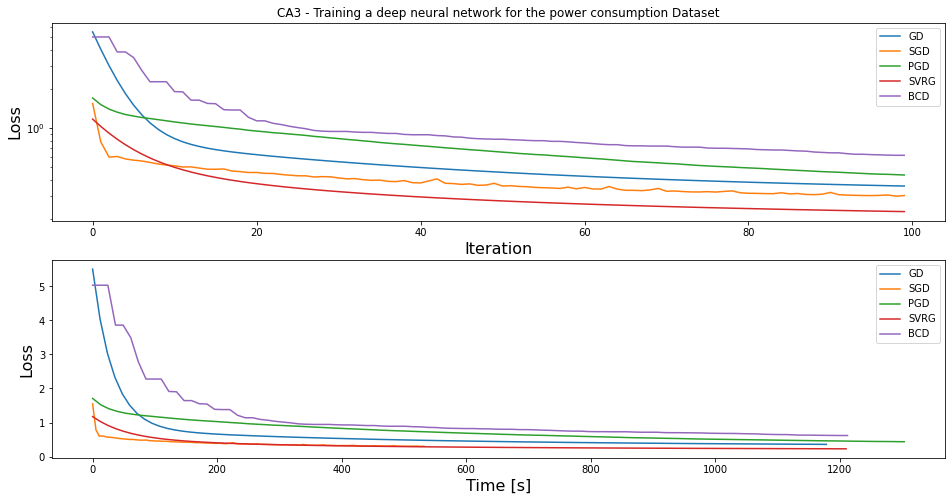

In [ ]:
# Plot results

# Define plotting variables
fig, ax = plt.subplots(2, 1, figsize=(16, 8))

ax[0].legend(loc="upper right")
ax[0].set_xlabel(r"Iteration", fontsize=16)
ax[0].set_ylabel("Loss", fontsize=16)
ax[0].set_title("CA3 - Training a deep neural network for the power consumption Dataset")
ax[0].set_yscale('log')

ax[0].plot(loss_train_GD, label="GD")
ax[0].plot(loss_train_SGD, label="SGD")
ax[0].plot(loss_train_PGD, label="PGD")
ax[0].plot(loss_train_SVRG, label="SVRG")
ax[0].plot(loss_train_BCD, label="BCD")
ax[0].legend()



ax[1].legend(loc="upper right")
ax[1].set_xlabel(r"Time [s]", fontsize=16)
ax[1].set_ylabel("Loss", fontsize=16)
ax[1].plot((end_GD-start_GD)/iterations*np.arange(iterations) ,loss_train_GD, label="GD")
ax[1].plot((end_SGD-start_SGD)/iterations*np.arange(iterations) ,loss_train_SGD, label="SGD")
ax[1].plot((end_PGD-start_PGD)/iterations*np.arange(iterations) ,loss_train_PGD, label="PGD")
ax[1].plot((end_SVRG-start_SVRG)/iterations*np.arange(iterations) ,loss_train_SVRG, label="SVRG")
ax[1].plot((end_BCD-start_BCD)/iterations*np.arange(iterations) ,loss_train_BCD, label="BCD")
ax[1].legend()
plt.savefig("power.png")

# Accuracy of the test set
print("Accuracy: ", "GD", Acc_GD, "SGD", Acc_SGD, "PGD", Acc_PGD, "SVRG", Acc_SVRG, "BGD", Acc_BCD)
# Convergence time
print("Training time: ", "GD:", int(end_GD-start_GD), "SGD", int(end_SGD-start_SGD), "PGD", int(end_PGD-start_PGD), 
      "SVRG", int(end_SVRG-start_SVRG),"BGD", int(end_BCD-start_BCD))

